Math 5750/6880: Mathematics of Data Science \
Project 3

# 1. Fashion-MNIST image classification using sklearn

In [2]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(len(X_train), -1)
X_test  = X_test.reshape(len(X_test), -1)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Training time for MLP: 38.2077 seconds
Accuracy for MLP: 0.8777


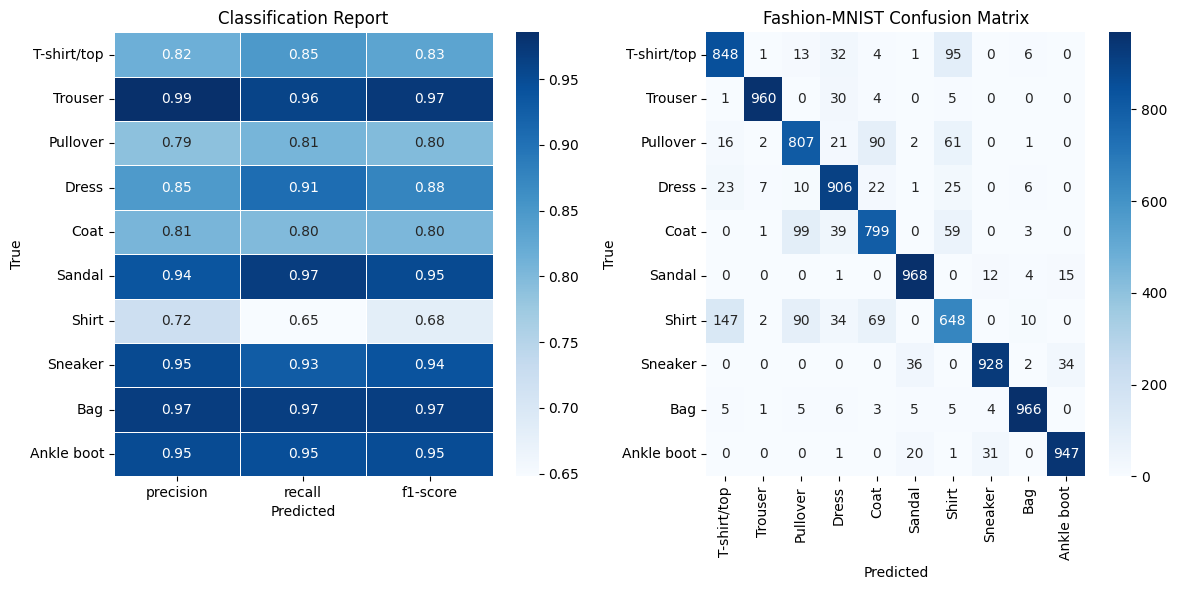

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

mlp = MLPClassifier(
    hidden_layer_sizes=(50, 50, 50), #Number of hidden layers and neurons
    activation='relu', #Activation function
    solver='adam', #Optimization method and the learning rate
    alpha=0.0001, #Regularization
    early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, #Early stopping
    max_iter=200, #To pevent it from taking forever
    random_state=1)

#The following options were tried to generate the graphics for the report. Only one was changed at a time.
#(100, )(Default), (128, 64), (50, 50, 50)
#Activation function: identity, logistic, tanh, relu(Defalut)
#Solver: lbfgs, sgd, adam(Default)
#Alpha=0.001(Default), 0.01, 0.1

STD = time.perf_counter()

mlp.fit(X_train, y_train)

ETD = time.perf_counter()

print(f"Training time for MLP: {ETD - STD:0.4f} seconds")

y_pred = mlp.predict(X_test)

ADefault = accuracy_score(y_test, y_pred)
print(f"Accuracy for MLP: {ADefault}")

CRDefault = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
if 'accuracy' in CRDefault:
    del CRDefault['accuracy']
if 'macro avg' in CRDefault:
    del CRDefault['macro avg']
if 'weighted avg' in CRDefault:
    del CRDefault['weighted avg']

CMDefault = confusion_matrix(y_test, y_pred)

#Plot for MLP
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(pd.DataFrame(CRDefault).iloc[:-1, :].T, annot=True, ax=ax1, cmap='Blues', fmt='.2f', linewidths=.5)
ax1.set_title('Classification Report')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

sns.heatmap(CMDefault, annot=True, fmt="d", ax=ax2, cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True")
ax2.set_title("Fashion-MNIST Confusion Matrix")

plt.tight_layout()
plt.show()



# 3. Fashion-MNIST image classification  using pytorch

In [7]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load Fashion-MNIST
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# scale to [0,1], add channel dimension -> (N, 1, 28, 28)
X_train = (X_train.astype("float32") / 255.0)[:, None, :, :]
X_test  = (X_test.astype("float32")  / 255.0)[:,  None, :, :]

y_train = y_train.astype(np.int64)
y_test  = y_test.astype(np.int64)

# train/val split: last 10k of train as validation
X_tr, X_val = X_train[:50000], X_train[50000:]
y_tr, y_val = y_train[:50000], y_train[50000:]

# wrap in PyTorch TensorDatasets and DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_tr),  torch.from_numpy(y_tr))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

Using device: cuda


Epoch 1/10: 100%|██████████| 391/391 [00:01<00:00, 313.41it/s]


Epoch 1: Train loss=0.6320, acc=0.7672 | Val loss=0.4244, acc=0.8427


Epoch 2/10: 100%|██████████| 391/391 [00:01<00:00, 306.86it/s]


Epoch 2: Train loss=0.4214, acc=0.8459 | Val loss=0.3883, acc=0.8594


Epoch 3/10: 100%|██████████| 391/391 [00:01<00:00, 302.20it/s]


Epoch 3: Train loss=0.3785, acc=0.8634 | Val loss=0.3518, acc=0.8736


Epoch 4/10: 100%|██████████| 391/391 [00:01<00:00, 305.85it/s]


Epoch 4: Train loss=0.3598, acc=0.8684 | Val loss=0.3479, acc=0.8734


Epoch 5/10: 100%|██████████| 391/391 [00:01<00:00, 297.73it/s]


Epoch 5: Train loss=0.3407, acc=0.8739 | Val loss=0.3713, acc=0.8699


Epoch 6/10: 100%|██████████| 391/391 [00:01<00:00, 300.08it/s]


Epoch 6: Train loss=0.3266, acc=0.8785 | Val loss=0.3558, acc=0.8717


Epoch 7/10: 100%|██████████| 391/391 [00:01<00:00, 248.06it/s]


Epoch 7: Train loss=0.3173, acc=0.8822 | Val loss=0.3173, acc=0.8848


Epoch 8/10: 100%|██████████| 391/391 [00:01<00:00, 267.48it/s]


Epoch 8: Train loss=0.3077, acc=0.8863 | Val loss=0.3242, acc=0.8867


Epoch 9/10: 100%|██████████| 391/391 [00:01<00:00, 300.95it/s]


Epoch 9: Train loss=0.3008, acc=0.8876 | Val loss=0.3202, acc=0.8858


Epoch 10/10: 100%|██████████| 391/391 [00:01<00:00, 301.79it/s]


Epoch 10: Train loss=0.2901, acc=0.8913 | Val loss=0.3414, acc=0.8751

Test loss: 0.3609, accuracy: 0.8672


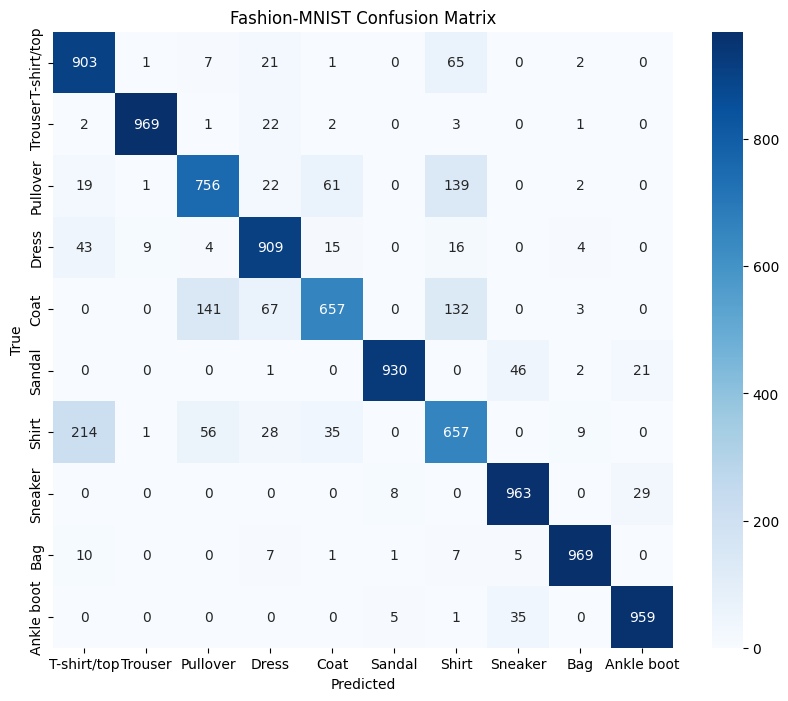


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.76      0.90      0.82      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.78      0.76      0.77      1000
       Dress       0.84      0.91      0.88      1000
        Coat       0.85      0.66      0.74      1000
      Sandal       0.99      0.93      0.96      1000
       Shirt       0.64      0.66      0.65      1000
     Sneaker       0.92      0.96      0.94      1000
         Bag       0.98      0.97      0.97      1000
  Ankle boot       0.95      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [8]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm  # for progress bars

# In colab, you should ``change runtime type'' to GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Define a simple fully connected network ---
class FashionMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = FashionMLP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

# --- Training loop ---
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X.size(0)
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item() * X.size(0)
                val_correct += (outputs.argmax(1) == y).sum().item()
                val_total += y.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}: "
              f"Train loss={train_loss:.4f}, acc={train_acc:.4f} | "
              f"Val loss={val_loss:.4f}, acc={val_acc:.4f}")

# --- Train ---
train_model(model, train_loader, val_loader, epochs=10)

# class FashionCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout(0.25)
#         self.fc1 = nn.Linear(64 * 14 * 14, 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.dropout(x)
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x
# model = FashionCNN().to(device)

# # --- Loss and optimizer ---
# criterion = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=1e-3)

# # --- Training loop ---
# def train_model(model, train_loader, val_loader, epochs=10):
#     for epoch in range(epochs):
#         model.train()
#         total_loss, correct, total = 0, 0, 0
#         for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
#             X, y = X.to(device), y.to(device)
#             optimizer.zero_grad()
#             outputs = model(X)
#             loss = criterion(outputs, y)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item() * X.size(0)
#             correct += (outputs.argmax(1) == y).sum().item()
#             total += y.size(0)

#         train_loss = total_loss / total
#         train_acc = correct / total

#         # --- Validation ---
#         model.eval()
#         val_loss, val_correct, val_total = 0, 0, 0
#         with torch.no_grad():
#             for X, y in val_loader:
#                 X, y = X.to(device), y.to(device)
#                 outputs = model(X)
#                 loss = criterion(outputs, y)
#                 val_loss += loss.item() * X.size(0)
#                 val_correct += (outputs.argmax(1) == y).sum().item()
#                 val_total += y.size(0)

#         val_loss /= val_total
#         val_acc = val_correct / val_total

#         print(f"Epoch {epoch+1}: "
#               f"Train loss={train_loss:.4f}, acc={train_acc:.4f} | "
#               f"Val loss={val_loss:.4f}, acc={val_acc:.4f}")

# # --- Run training ---
# train_model(model, train_loader, val_loader, epochs=10)

# from torchvision import models, transforms
# from torch.utils.data import DataLoader, TensorDataset

# # --- Step 1: Preprocessing ---
# # Convert grayscale (1x28x28) → RGB (3x224x224)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # grayscale → RGB
# ])

# class TransformedDataset(torch.utils.data.Dataset):
#     def __init__(self, dataset, transform=None):
#         self.dataset = dataset
#         self.transform = transform
#     def __len__(self):
#         return len(self.dataset)
#     def __getitem__(self, idx):
#         x, y = self.dataset[idx]
#         if self.transform:
#             x = self.transform(x)
#         return x, y

# train_tf = TransformedDataset(train_ds, transform)
# val_tf   = TransformedDataset(val_ds, transform)
# test_tf  = TransformedDataset(test_ds, transform)

# train_loader = DataLoader(train_tf, batch_size=64, shuffle=True)
# val_loader   = DataLoader(val_tf, batch_size=128, shuffle=False)
# test_loader  = DataLoader(test_tf, batch_size=128, shuffle=False)

# # --- Step 2: Load pretrained model ---

# model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# # --- Step 3: Modify classifier for 10 Fashion-MNIST classes ---
# for param in model.parameters():
#     param.requires_grad = False  # freeze all layers

# num_features = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(num_features, 256),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(256, 10)
# )

# # --- Step 4: Fine-tune last layers ---
# for param in model.fc.parameters():
#     param.requires_grad = True  # unfreeze classifier

# model = model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

# # --- Step 5: Training loop ---
# def train_model(model, train_loader, val_loader, epochs=5):
#     for epoch in range(epochs):
#         model.train()
#         total_loss, correct, total = 0, 0, 0
#         for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
#             X, y = X.to(device), y.to(device)
#             optimizer.zero_grad()
#             outputs = model(X)
#             loss = criterion(outputs, y)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item() * X.size(0)
#             correct += (outputs.argmax(1) == y).sum().item()
#             total += y.size(0)

#         train_loss = total_loss / total
#         train_acc = correct / total

#         # Validation
#         model.eval()
#         val_loss, val_correct, val_total = 0, 0, 0
#         with torch.no_grad():
#             for X, y in val_loader:
#                 X, y = X.to(device), y.to(device)
#                 outputs = model(X)
#                 loss = criterion(outputs, y)
#                 val_loss += loss.item() * X.size(0)
#                 val_correct += (outputs.argmax(1) == y).sum().item()
#                 val_total += y.size(0)

#         val_loss /= val_total
#         val_acc = val_correct / val_total

#         print(f"Epoch {epoch+1}: "
#               f"Train loss={train_loss:.4f}, acc={train_acc:.4f} | "
#               f"Val loss={val_loss:.4f}, acc={val_acc:.4f}")

# train_model(model, train_loader, val_loader, epochs=5)

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Evaluate on test set ---
def evaluate_model(model, test_loader):
    model.eval()
    test_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            test_loss += loss.item() * X.size(0)
            preds = outputs.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= total
    test_acc = correct / total
    print(f"\nTest loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
    return np.array(all_labels), np.array(all_preds)

# --- Run test evaluation ---
labels, preds = evaluate_model(model, test_loader)

# --- Confusion matrix ---
cm = confusion_matrix(labels, preds)
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Fashion-MNIST Confusion Matrix")
plt.show()

# --- Classification report ---
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=class_names))